# I.Import et etudes fichiers

## import

In [3]:
# installations et imports des autres packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import fonctions as fc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

## Sheet data


In [4]:
# file path
data_file_path = "DisponibiliteAlimentaire_2017.csv"
# data_file_path = "/content/drive/MyDrive/OC/P9/DATA/DisponibiliteAlimentaire_2017.csv"
df_data = pd.read_csv(data_file_path)

In [5]:
# Utilisation de la fonction
fc.etude_fichier(df_data)

Nombre de colonnes : (176600, 14)

Le type est : 
 Code Domaine               object
Domaine                    object
Code zone                   int64
Zone                       object
Code Élément                int64
Élément                    object
Code Produit                int64
Produit                    object
Code année                  int64
Année                       int64
Unité                      object
Valeur                    float64
Symbole                    object
Description du Symbole     object
dtype: object

Nombre de valeurs uniques :
Code Domaine                 1
Domaine                      1
Code zone                  174
Zone                       174
Code Élément                17
Élément                     17
Code Produit                98
Produit                     98
Code année                   1
Année                        1
Unité                        4
Valeur                    7250
Symbole                      2
Description du Symbole     

**Unités**

Unité = 'Milliers de tonnes', 'kg', Kcal/personne/jour', 'g/personne/jour'

Description du Symbole = 'Données standardisées', 'Donnée calculée'

In [6]:
# Sélection des colonnes
colonnes_a_supprimer = ['Code Domaine', 'Code zone','Description du Symbole', 'Code Élément', 'Code Produit',  'Code année', 'Symbole', "Domaine"]

# Supprimer les colonnes du dataframe final
df_data = df_data.drop(columns=colonnes_a_supprimer)

# Afficher les premières lignes du nouveau dataframe
df_data.head()

,Zone,Élément,Produit,Année,Unité,Valeur
0,Afghanistan,Production,Blé et produits,2017,Milliers de tonnes,4281.0
1,Afghanistan,Importations - Quantité,Blé et produits,2017,Milliers de tonnes,2302.0
2,Afghanistan,Variation de stock,Blé et produits,2017,Milliers de tonnes,-119.0
3,Afghanistan,Exportations - Quantité,Blé et produits,2017,Milliers de tonnes,0.0
4,Afghanistan,Disponibilité intérieure,Blé et produits,2017,Milliers de tonnes,6701.0


In [7]:
df_data = df_data[df_data['Produit'] == 'Viande de Volailles'] # On ne garde que les produits de type viande de volailles
df_data = df_data[df_data['Élément'].isin(['Production', 'Importations - Quantité', 'Exportations - Quantité', 'Disponibilité intérieure', 'Disponibilité de protéines en quantité (g/personne/jour)'])] # On ne garde que les éléments de type nourriture
df_data.head(10)

,Zone,Élément,Produit,Année,Unité,Valeur
651,Afghanistan,Production,Viande de Volailles,2017,Milliers de tonnes,28.00
652,Afghanistan,Importations - Quantité,Viande de Volailles,2017,Milliers de tonnes,29.00
654,Afghanistan,Disponibilité intérieure,Viande de Volailles,2017,Milliers de tonnes,57.00
660,Afghanistan,Disponibilité de protéines en quantité (g/pers...,Viande de Volailles,2017,g/personne/jour,0.54
1704,Afrique du Sud,Production,Viande de Volailles,2017,Milliers de tonnes,1667.00
1705,Afrique du Sud,Importations - Quantité,Viande de Volailles,2017,Milliers de tonnes,514.00
1707,Afrique du Sud,Exportations - Quantité,Viande de Volailles,2017,Milliers de tonnes,63.00
1708,Afrique du Sud,Disponibilité intérieure,Viande de Volailles,2017,Milliers de tonnes,2118.00
1715,Afrique du Sud,Disponibilité de protéines en quantité (g/pers...,Viande de Volailles,2017,g/personne/jour,14.11
2713,Albanie,Production,Viande de Volailles,2017,Milliers de tonnes,13.00


In [8]:
# Utilisez la fonction pivot_table pour effectuer la transformation
df_data = df_data.pivot_table(index=['Zone'],
                                columns='Élément',
                                values='Valeur',
                                aggfunc='sum').reset_index()

# Affiche le DataFrame transformé
df_data.head()

Élément,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production
0,Afghanistan,0.54,57.0,NaN,29.0,28.0
1,Afrique du Sud,14.11,2118.0,63.0,514.0,1667.0
2,Albanie,6.26,47.0,0.0,38.0,13.0
3,Algérie,1.97,277.0,0.0,2.0,275.0
4,Allemagne,7.96,1739.0,646.0,842.0,1514.0


## sheet population

In [9]:
# file path
population_file_path = "Population_2000_2018.csv"
# population_file_path = "/content/drive/MyDrive/OC/P9/DATA/Population_2000_2018.csv"
df_population = pd.read_csv(population_file_path)

### Etude

In [10]:
df_population.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2000,2000,1000 personnes,20779.953,X,Sources internationales sûres,NaN
1,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2001,2001,1000 personnes,21606.988,X,Sources internationales sûres,NaN
2,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2002,2002,1000 personnes,22600.770,X,Sources internationales sûres,NaN
3,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2003,2003,1000 personnes,23680.871,X,Sources internationales sûres,NaN
4,OA,Séries temporelles annuelles,2,Afghanistan,511,Population totale,3010,Population-Estimations,2004,2004,1000 personnes,24726.684,X,Sources internationales sûres,NaN


In [11]:
fc.etude_fichier(df_population)

Nombre de colonnes : (4411, 15)

Le type est : 
 Code Domaine               object
Domaine                    object
Code zone                   int64
Zone                       object
Code Élément                int64
Élément                    object
Code Produit                int64
Produit                    object
Code année                  int64
Année                       int64
Unité                      object
Valeur                    float64
Symbole                    object
Description du Symbole     object
Note                       object
dtype: object

Nombre de valeurs uniques :
Code Domaine                 1
Domaine                      1
Code zone                  238
Zone                       238
Code Élément                 1
Élément                      1
Code Produit                 1
Produit                      1
Code année                  19
Année                       19
Unité                        1
Valeur                    4398
Symbole                   

In [12]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['Code Domaine', 'Code zone', 'Code Élément', 'Élément','Code Produit', 'Code année', 'Unité', 'Symbole', 'Description du Symbole', 'Note', "Domaine", "Produit"]

# Supprimer les colonnes du dataframe final
df_population = df_population.drop(columns=colonnes_a_supprimer)

# Renommer la colonne
df_population = df_population.rename(columns={"Valeur": "Population"})

# Afficher les premières lignes du nouveau dataframe
df_population.head()

,Zone,Année,Population
0,Afghanistan,2000,20779.953
1,Afghanistan,2001,21606.988
2,Afghanistan,2002,22600.770
3,Afghanistan,2003,23680.871
4,Afghanistan,2004,24726.684


In [13]:
# Convertion en int
df_population['Population'] = pd.to_numeric(df_population['Population'], errors='coerce')

# Convertion en integer
df_population['Population'] = df_population['Population'].astype(int)

# Multiplier par1000
df_population['Population'] = df_population['Population']*1000

# Afficher les premières lignes du nouveau dataframe
df_population = df_population[df_population['Année'] == 2017]

df_population.head(10)

,Zone,Année,Population
17,Afghanistan,2017,36296000
36,Afrique du Sud,2017,57009000
55,Albanie,2017,2884000
74,Algérie,2017,41389000
93,Allemagne,2017,82658000
112,Andorre,2017,77000
131,Angola,2017,29816000
150,Anguilla,2017,14000
169,Antigua-et-Barbuda,2017,95000
188,Antilles néerlandaises (ex),2017,275000


## sheet PIB

In [14]:
# # file path
population_file_path = "PIB_par_hab_2017.csv"
# population_file_path = "/content/drive/MyDrive/OC/P9/DATA/PIB_par_hab_2017.csv"
df_pib = pd.read_csv(population_file_path)

In [15]:
df_pib.head()

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,MK,Indicateurs macro,4,Afghanistan,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,530.149831,X,Ciffre de sources internationales,NaN
1,MK,Indicateurs macro,710,Afrique du Sud,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,6723.928582,X,Ciffre de sources internationales,NaN
2,MK,Indicateurs macro,8,Albanie,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,4521.752217,X,Ciffre de sources internationales,NaN
3,MK,Indicateurs macro,12,Algérie,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,4134.936055,X,Ciffre de sources internationales,NaN
4,MK,Indicateurs macro,276,Allemagne,6119,Valeur US $ par habitant,22008,Produit Intérieur Brut,2017,2017,US$,44670.222282,X,Ciffre de sources internationales,NaN


In [16]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['Année','Code Domaine', 'Code zone (M49)', 'Code Élément', 'Élément','Code Produit', 'Code année', 'Unité', 'Symbole', 'Description du Symbole', 'Note', "Domaine", "Produit"]

# Supprimer les colonnes du dataframe final
df_pib = df_pib.drop(columns=colonnes_a_supprimer)

# Renommer la colonne
df_pib = df_pib.rename(columns={"Valeur": "PIB US $ par habitant"})

# Afficher les premières lignes du nouveau dataframe
df_pib.head()

,Zone,PIB US $ par habitant
0,Afghanistan,530.149831
1,Afrique du Sud,6723.928582
2,Albanie,4521.752217
3,Algérie,4134.936055
4,Allemagne,44670.222282


## Sheet Sous-alimentation

In [17]:
# file path
population_file_path = "nb_personnes_sous_alimenté_2017.csv"
# population_file_path = "/content/drive/MyDrive/OC/P9/DATA/nb_personnes_sous_alimenté_2017.csv"
df_sous_nutrition = pd.read_csv(population_file_path)

In [18]:
df_sous_nutrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            204 non-null    object 
 1   Domaine                 204 non-null    object 
 2   Code zone (M49)         204 non-null    int64  
 3   Zone                    204 non-null    object 
 4   Code Élément            204 non-null    int64  
 5   Élément                 204 non-null    object 
 6   Code Produit            204 non-null    int64  
 7   Produit                 204 non-null    object 
 8   Code année              204 non-null    int64  
 9   Année                   204 non-null    object 
 10  Unité                   204 non-null    object 
 11  Valeur                  117 non-null    object 
 12  Symbole                 204 non-null    object 
 13  Description du Symbole  204 non-null    object 
 14  Note                    0 non-null      fl

In [19]:
df_sous_nutrition.head()

,Code Domaine,Domaine,Code zone (M49),Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole,Note
0,FS,Données de la sécurité alimentaire,528,Pays-Bas (Royaume des),6132,Valeur,210011,Nombre de personnes sous-alimentées (millions)...,20162018,2016-2018,millions No,NaN,Q,Valeur manquante; supprimée,NaN
1,FS,Données de la sécurité alimentaire,4,Afghanistan,6132,Valeur,210011,Nombre de personnes sous-alimentées (millions)...,20162018,2016-2018,millions No,8.1,E,Valeur estimée,NaN
2,FS,Données de la sécurité alimentaire,710,Afrique du Sud,6132,Valeur,210011,Nombre de personnes sous-alimentées (millions)...,20162018,2016-2018,millions No,3.2,E,Valeur estimée,NaN
3,FS,Données de la sécurité alimentaire,8,Albanie,6132,Valeur,210011,Nombre de personnes sous-alimentées (millions)...,20162018,2016-2018,millions No,0.1,E,Valeur estimée,NaN
4,FS,Données de la sécurité alimentaire,12,Algérie,6132,Valeur,210011,Nombre de personnes sous-alimentées (millions)...,20162018,2016-2018,millions No,1.1,E,Valeur estimée,NaN


In [20]:
df_sous_nutrition['Valeur'] = df_sous_nutrition['Valeur'].replace('<0.1', '0.1')
df_sous_nutrition['Valeur'] = df_sous_nutrition['Valeur'].astype(float)

In [21]:
# Liste des colonnes à supprimer
colonnes_a_supprimer = ['Année','Code Domaine', 'Code zone (M49)', 'Code Élément', 'Élément','Code Produit', 'Code année', 'Unité', 'Symbole', 'Description du Symbole', 'Note', "Domaine", "Produit"]

# Supprimer les colonnes du dataframe final
df_sous_nutrition = df_sous_nutrition.drop(columns=colonnes_a_supprimer)

# Renommer la colonne
df_sous_nutrition = df_sous_nutrition.rename(columns={"Valeur": "Nombre de personnes sous-alimentées"})

# Afficher les premières lignes
df_sous_nutrition.head()

,Zone,Nombre de personnes sous-alimentées
0,Pays-Bas (Royaume des),NaN
1,Afghanistan,8.1
2,Afrique du Sud,3.2
3,Albanie,0.1
4,Algérie,1.1


In [22]:
df_sous_nutrition.isnull().sum()

Zone                                    0
Nombre de personnes sous-alimentées    87
dtype: int64

In [23]:
df_sous_nutrition.shape

(204, 2)

In [24]:
df_sous_nutrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Zone                                 204 non-null    object 
 1   Nombre de personnes sous-alimentées  117 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.3+ KB


# II.Jointures

In [25]:
# Jointures des deux df
data = pd.merge(df_data, df_population, on=['Zone'])
data.head()

,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production,Année,Population
0,Afghanistan,0.54,57.0,NaN,29.0,28.0,2017,36296000
1,Afrique du Sud,14.11,2118.0,63.0,514.0,1667.0,2017,57009000
2,Albanie,6.26,47.0,0.0,38.0,13.0,2017,2884000
3,Algérie,1.97,277.0,0.0,2.0,275.0,2017,41389000
4,Allemagne,7.96,1739.0,646.0,842.0,1514.0,2017,82658000


In [26]:
data = pd.merge(data, df_pib, on=['Zone'])

In [27]:
data.head()

,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production,Année,Population,PIB US $ par habitant
0,Afghanistan,0.54,57.0,NaN,29.0,28.0,2017,36296000,530.149831
1,Afrique du Sud,14.11,2118.0,63.0,514.0,1667.0,2017,57009000,6723.928582
2,Albanie,6.26,47.0,0.0,38.0,13.0,2017,2884000,4521.752217
3,Algérie,1.97,277.0,0.0,2.0,275.0,2017,41389000,4134.936055
4,Allemagne,7.96,1739.0,646.0,842.0,1514.0,2017,82658000,44670.222282


In [28]:
data = pd.merge(data, df_sous_nutrition, on=['Zone'])
data.head()

,Zone,Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure,Exportations - Quantité,Importations - Quantité,Production,Année,Population,PIB US $ par habitant,Nombre de personnes sous-alimentées
0,Afghanistan,0.54,57.0,NaN,29.0,28.0,2017,36296000,530.149831,8.1
1,Afrique du Sud,14.11,2118.0,63.0,514.0,1667.0,2017,57009000,6723.928582,3.2
2,Albanie,6.26,47.0,0.0,38.0,13.0,2017,2884000,4521.752217,0.1
3,Algérie,1.97,277.0,0.0,2.0,275.0,2017,41389000,4134.936055,1.1
4,Allemagne,7.96,1739.0,646.0,842.0,1514.0,2017,82658000,44670.222282,NaN


# III.Manipulation des données

## début de l'analsye

In [29]:
#transformation en Kg
data['Disponibilité intérieure'] = data['Disponibilité de protéines en quantité (g/personne/jour)']* 1000000
data['Importations - Quantité'] = data['Importations - Quantité'] * 1000000
data['Production'] = data['Production']  * 1000000
data['Exportations - Quantité'] = data['Exportations - Quantité']  * 1000000

# mettre à la bonne échelle
df_sous_nutrition['Nombre de personnes sous-alimentées'] = df_sous_nutrition['Nombre de personnes sous-alimentées']*1000000
data.head()

#pondération par la population
data['Disponibilité intérieure'] = data['Disponibilité intérieure'] / data['Population']
data['Importations - Quantité'] = data['Importations - Quantité'] / data['Population']
data['Exportations - Quantité'] = data['Exportations - Quantité'] / data['Population']
data['Production'] = data['Production'] / data['Population']
data['Disponibilité de protéines en quantité (g/personne/jour)'] = data['Disponibilité de protéines en quantité (g/personne/jour)'] * 365

#renommage des colonnes
data.rename(columns={'Disponibilité de protéines en quantité (g/personne/jour)': 'Disponibilité de protéines en quantité (g/personne/an)'}, inplace=True)
data.rename(columns={'Disponibilité intérieure': 'Disponibilité intérieure/ Population'}, inplace=True)
data.rename(columns={'Exportations - Quantité': 'Exportations / Population'}, inplace=True)
data.rename(columns={'Importations - Quantité': 'Importations / Population'}, inplace=True)
data.rename(columns={'Production': 'Production / Population'}, inplace=True)

data.drop(columns=['Année'], inplace=True)
data.head()

,Zone,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,Population,PIB US $ par habitant,Nombre de personnes sous-alimentées
0,Afghanistan,197.10,0.014878,NaN,0.798986,0.771435,36296000,530.149831,8.1
1,Afrique du Sud,5150.15,0.247505,1.105089,9.016120,29.240997,57009000,6723.928582,3.2
2,Albanie,2284.90,2.170596,0.000000,13.176144,4.507628,2884000,4521.752217,0.1
3,Algérie,719.05,0.047597,0.000000,0.048322,6.644277,41389000,4134.936055,1.1
4,Allemagne,2905.40,0.096300,7.815335,10.186552,18.316436,82658000,44670.222282,NaN


In [30]:
data.describe()

,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,Population,PIB US $ par habitant,Nombre de personnes sous-alimentées
count,170.000000,170.000000,133.000000,168.000000,166.000000,1.700000e+02,170.000000,109.000000
mean,2588.000294,11.373962,3.828395,10.913868,15.981506,4.310589e+07,13765.047516,4.694495
std,2054.046301,41.531610,10.460170,18.737556,16.980156,1.539466e+08,19125.436165,17.091848
min,14.600000,0.000376,0.000000,0.000000,0.000000,5.200000e+04,414.740323,0.100000
25%,742.775000,0.111295,0.000000,0.410691,2.296087,2.854750e+06,1942.240459,0.200000
50%,2337.825000,0.528003,0.117426,3.688447,9.531078,9.608000e+06,5939.481873,1.300000
75%,3752.200000,2.239701,3.429796,11.724443,24.014310,3.078200e+07,16360.112585,3.900000
max,10172.550000,369.615385,90.747331,124.144539,76.307170,1.421021e+09,110203.008207,174.300000


## Valeurs manquantes

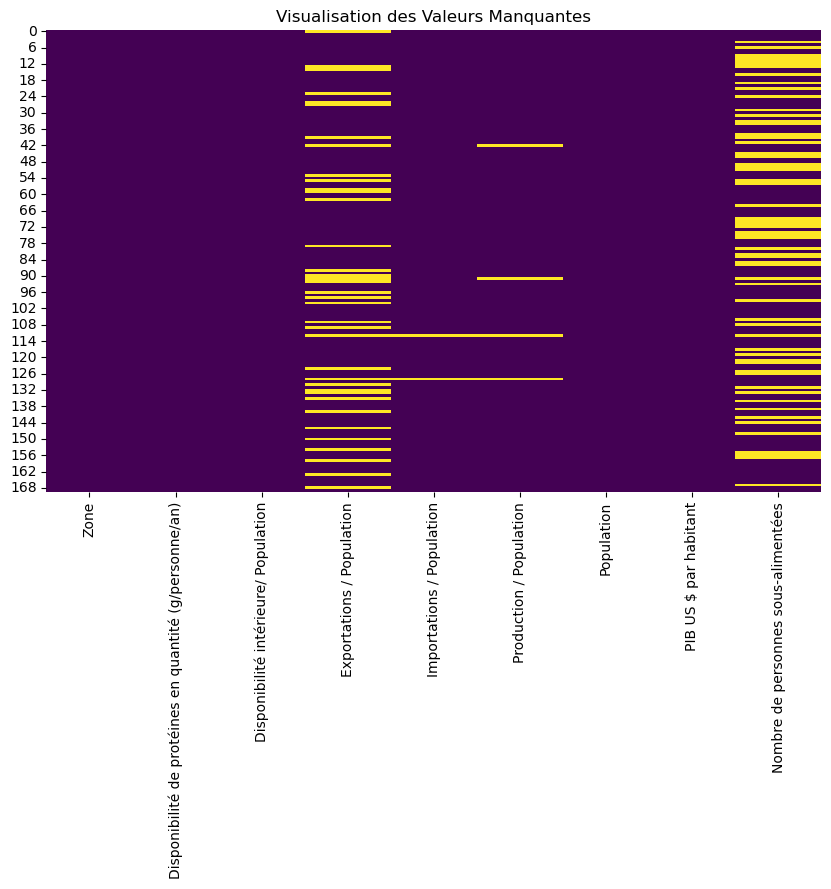

In [31]:
fc.visualiser_valeurs_manquantes(data)

Au vu des valeurs manquantes par colonne, on peut décider de supprimer la colonne avec la sous-nutrition car il manque trop de données pour pouvoir l'utiliser.

Pour les exportations, on peut partir du principe que les valeurs manquantes peuvent être remplacées par 0 car cela signifie que le pays n'a pas d'exportations du produit.

Pour les autres données, nous allons imputer la médiane à la place des NaN.

Pour la colonne Population nous allons la retirer également car elle est déjà présente dans l'étude via la pondération de chaque colonne

In [32]:
# drop la colonne
data.drop(columns=['Nombre de personnes sous-alimentées'], inplace=True)
data.drop(columns=['Population'], inplace = True)

In [33]:
# rempalce par 0
data['Exportations / Population'].fillna(0, inplace=True)
data['Importations / Population'].fillna(0, inplace=True)

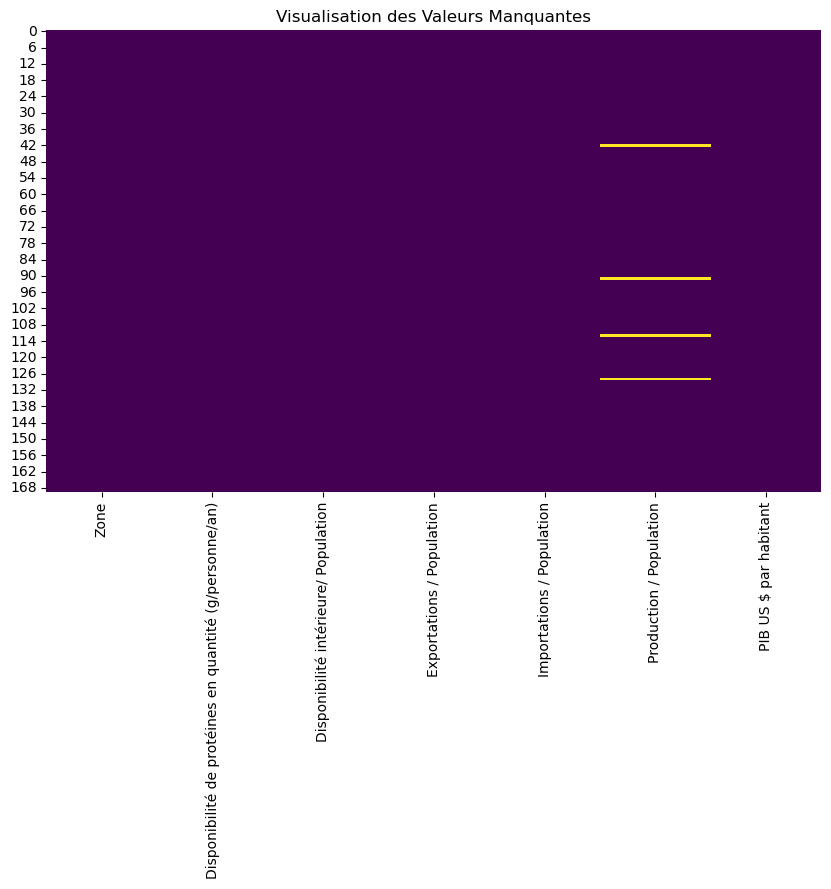

In [34]:
fc.visualiser_valeurs_manquantes(data)

In [35]:
data.dropna(inplace=True)

In [36]:
names = data.Zone.values
names

array(['Afghanistan', 'Afrique du Sud', 'Albanie', 'Algérie', 'Allemagne',
       'Angola', 'Antigua-et-Barbuda', 'Arabie saoudite', 'Argentine',
       'Arménie', 'Australie', 'Autriche', 'Azerbaïdjan', 'Bahamas',
       'Bangladesh', 'Barbade', 'Belgique', 'Belize',
       'Bolivie (État plurinational de)', 'Bosnie-Herzégovine',
       'Botswana', 'Brésil', 'Bulgarie', 'Burkina Faso', 'Bélarus',
       'Bénin', 'Cabo Verde', 'Cambodge', 'Cameroun', 'Canada', 'Chili',
       'Chine - RAS de Hong-Kong', 'Chine - RAS de Macao',
       'Chine, continentale', 'Chypre', 'Colombie', 'Congo', 'Costa Rica',
       'Croatie', 'Cuba', "Côte d'Ivoire", 'Danemark', 'Dominique',
       'El Salvador', 'Espagne', 'Estonie', 'Eswatini', 'Fidji',
       'Finlande', 'France', 'Fédération de Russie', 'Gabon', 'Gambie',
       'Ghana', 'Grenade', 'Grèce', 'Guatemala', 'Guinée',
       'Guinée-Bissau', 'Guyana', 'Géorgie', 'Haïti', 'Honduras',
       'Hongrie', 'Inde', 'Indonésie', "Iran (République islam

## Etude outliers

In [37]:
fc.etude_outliers(data,  seuil=2.0)

Le pourcentage de valeurs considérées comme des outliers en utilisant le Z-score au seuil 2.0 dans la colonne 'Disponibilité de protéines en quantité (g/personne/an)' est 4.22%
Le pourcentage de valeurs considérées comme des outliers en utilisant le Z-score au seuil 2.0 dans la colonne 'Disponibilité intérieure/ Population' est 4.22%
Le pourcentage de valeurs considérées comme des outliers en utilisant le Z-score au seuil 2.0 dans la colonne 'Exportations / Population' est 3.01%
Le pourcentage de valeurs considérées comme des outliers en utilisant le Z-score au seuil 2.0 dans la colonne 'Importations / Population' est 6.02%
Le pourcentage de valeurs considérées comme des outliers en utilisant le Z-score au seuil 2.0 dans la colonne 'Production / Population' est 5.42%
Le pourcentage de valeurs considérées comme des outliers en utilisant le Z-score au seuil 2.0 dans la colonne 'PIB US $ par habitant' est 6.02%


In [38]:
data.describe()

,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,2628.725602,11.581850,3.067328,10.880471,15.981506,13993.689262
std,2059.313177,42.005633,9.480544,18.812738,16.980156,19290.990212
min,14.600000,0.000376,0.000000,0.000000,0.000000,414.740323
25%,816.687500,0.111295,0.000000,0.389139,2.296087,1938.911891
50%,2403.525000,0.505031,0.000000,3.688447,9.531078,6031.146548
75%,3801.475000,2.239701,1.622688,11.647326,24.014310,17299.273689
max,10172.550000,369.615385,90.747331,124.144539,76.307170,110203.008207


## Normalisation

## Standard

In [39]:
# Créez un MinMaxScaler
scaler = StandardScaler()

colonnes_a_normaliser = data.select_dtypes(include='number').columns.tolist()

# Normalisez les colonnes
data[colonnes_a_normaliser] = scaler.fit_transform(data[colonnes_a_normaliser])

# Afficher les premières lignes du DataFrame
data.head()

,Zone,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
0,Afghanistan,-1.184367,-0.276200,-0.324518,-0.537508,-0.898466,-0.700030
1,Afrique du Sud,1.228105,-0.270646,-0.207602,-0.099400,0.783244,-0.377988
2,Albanie,-0.167466,-0.224725,-0.324518,0.122397,-0.677767,-0.492489
3,Algérie,-0.930142,-0.275419,-0.324518,-0.577530,-0.551554,-0.512601
4,Allemagne,0.134759,-0.274256,0.502331,-0.036997,0.137925,1.595012


In [40]:
data_num = data.select_dtypes(include='number')

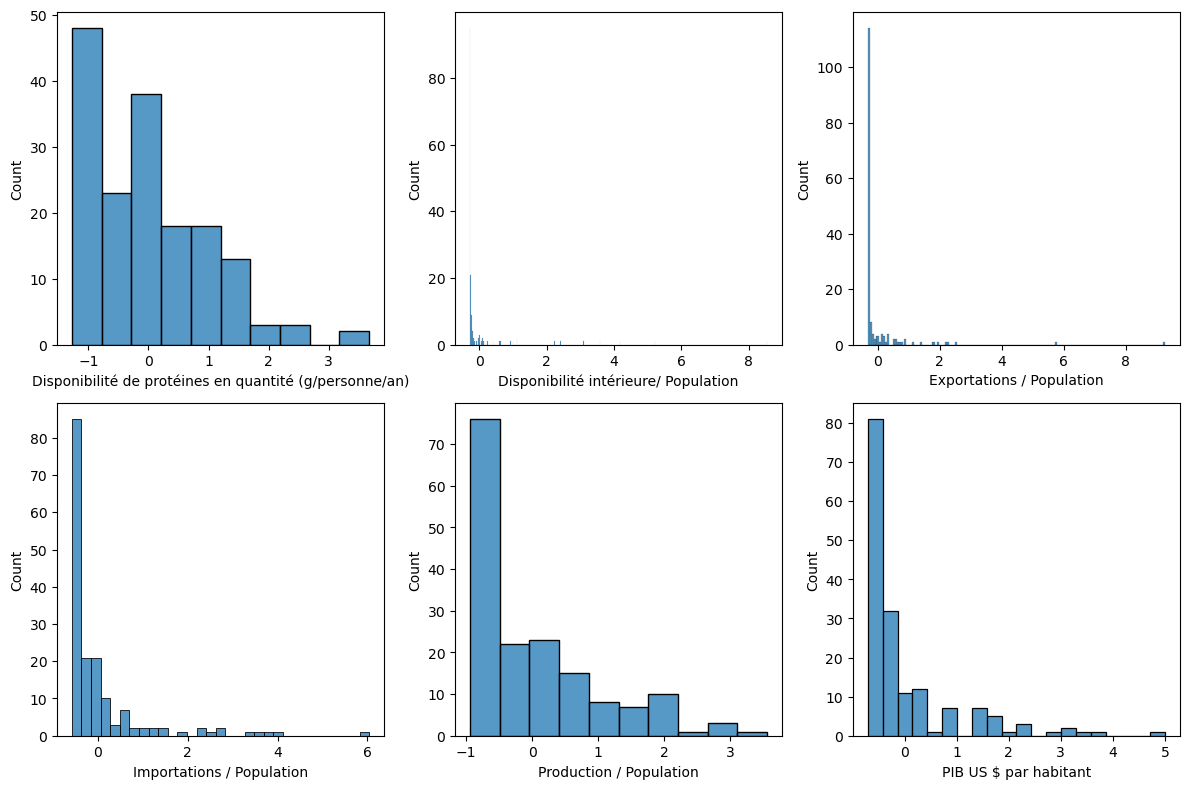

In [41]:
# tracer les distributions des dimensions
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

sns.histplot(data_num['Disponibilité de protéines en quantité (g/personne/an)'], ax=axes[0, 0])
sns.histplot(data_num['Disponibilité intérieure/ Population'], ax=axes[0, 1])
sns.histplot(data_num['Exportations / Population'], ax=axes[0, 2])
sns.histplot(data_num['Importations / Population'], ax=axes[1, 0])
sns.histplot(data_num['Production / Population'], ax=axes[1, 1])
sns.histplot(data_num['PIB US $ par habitant'], ax=axes[1, 2])
plt.tight_layout()
plt.show()

c:\Users\antoi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


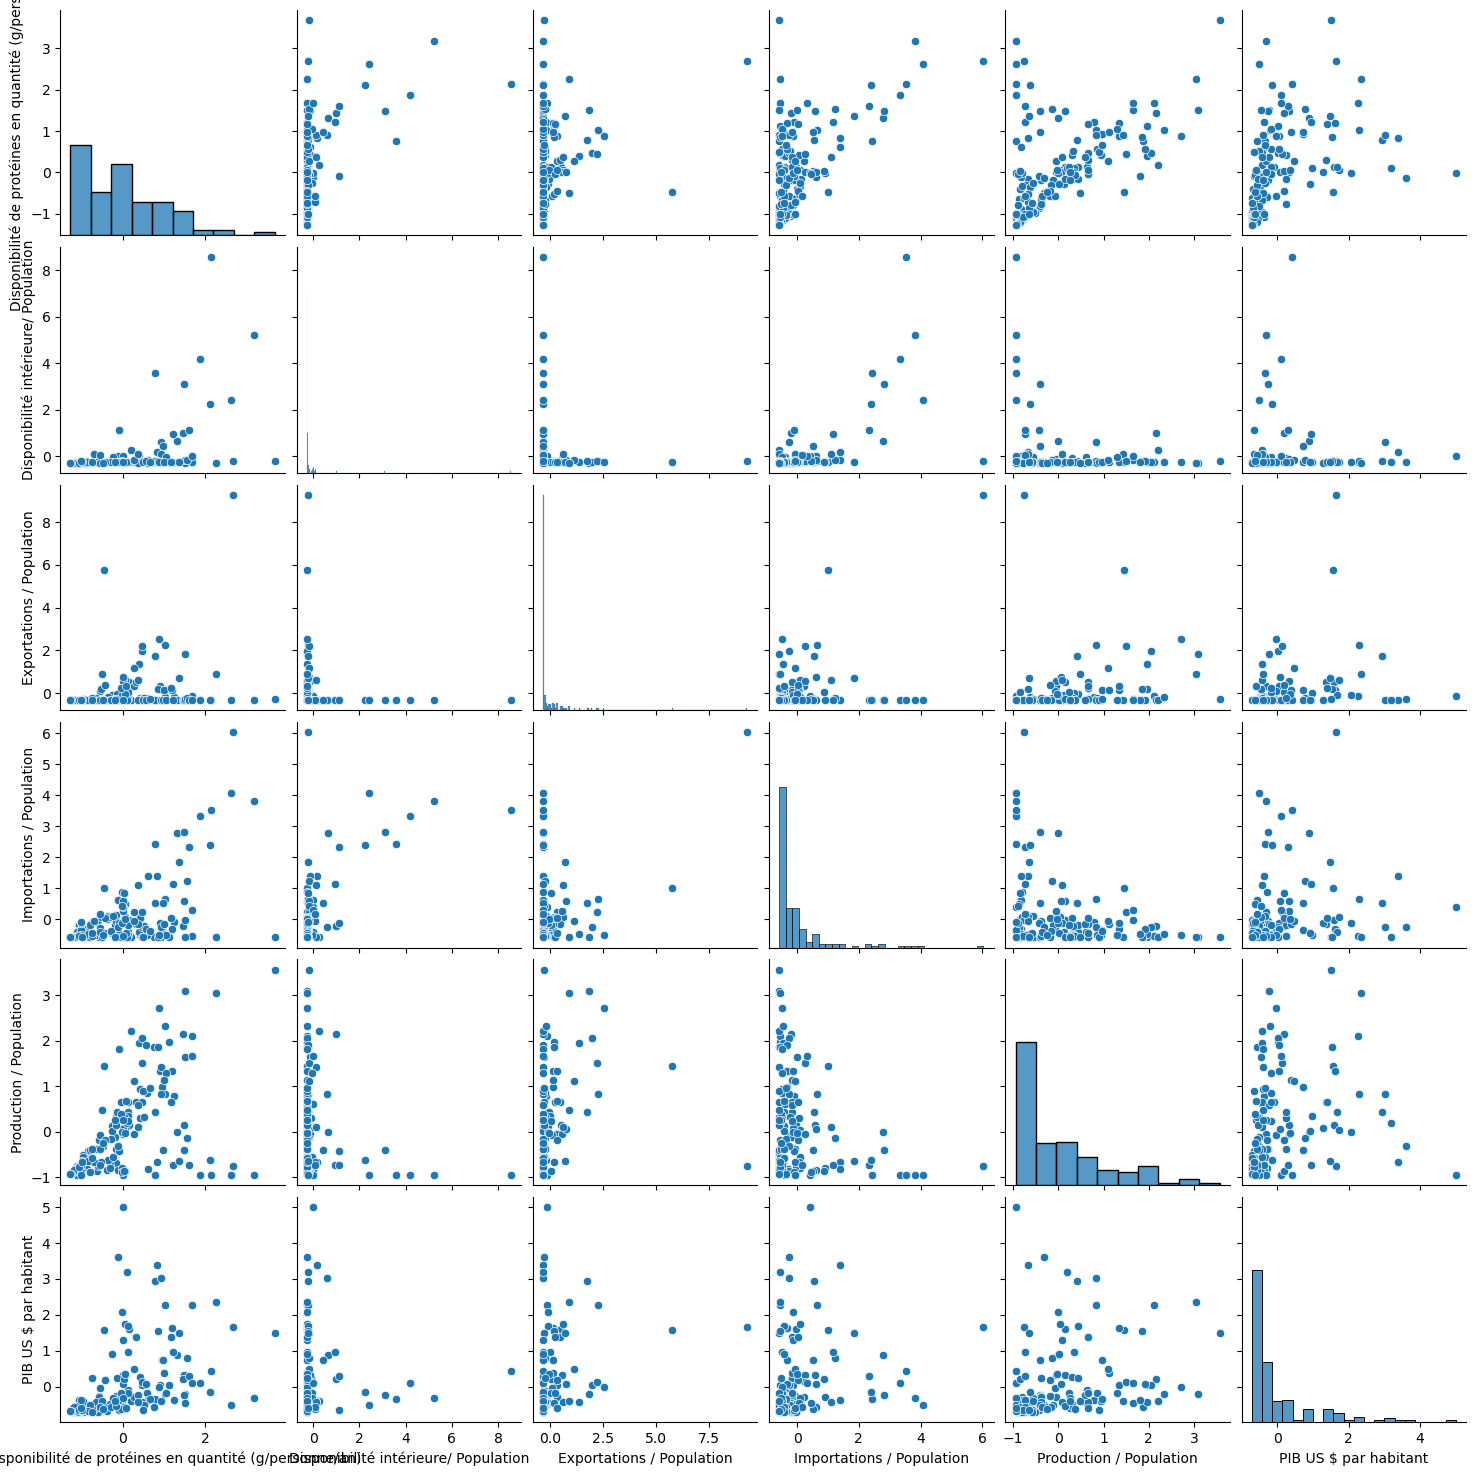

In [42]:
sns.pairplot(data)

## Correlations

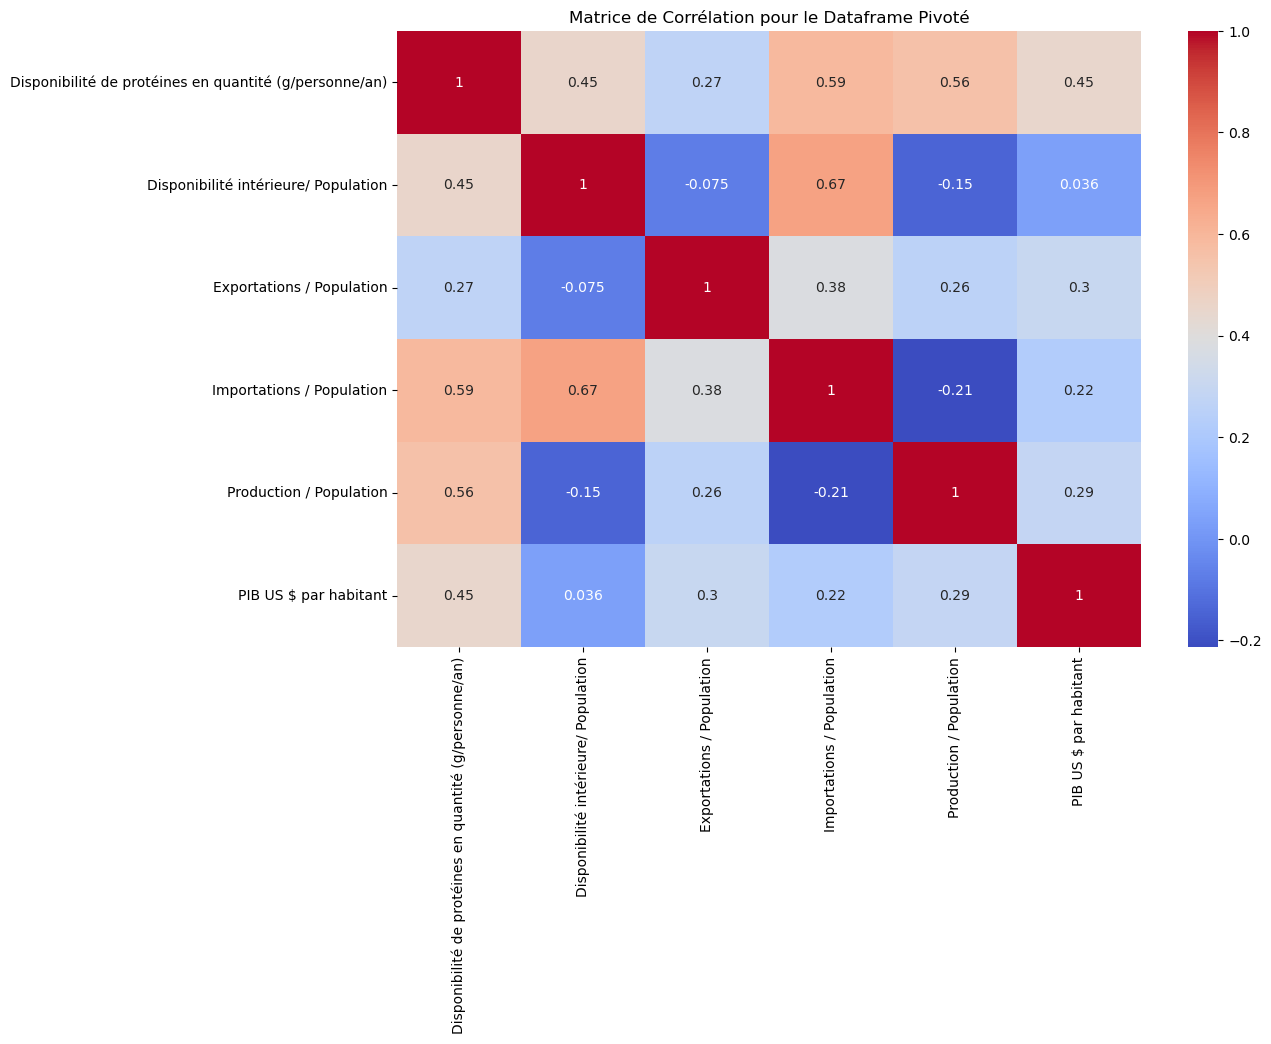

In [43]:
# Calcul de la matrice de corrélation pour le dataframe pivoté
correlation = data_num.corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation pour le Dataframe Pivoté')
plt.show()

## POIDS des colonnes

In [44]:
# # Suppose 'column1' and 'column2' are the columns you want to give more weight
# weight = 2  # Change this to the weight you want
# df['column1'] = df['column1'] * weight
# df['column2'] = df['column2'] * weight

# # Then perform the clustering

# IV.Dendogramme

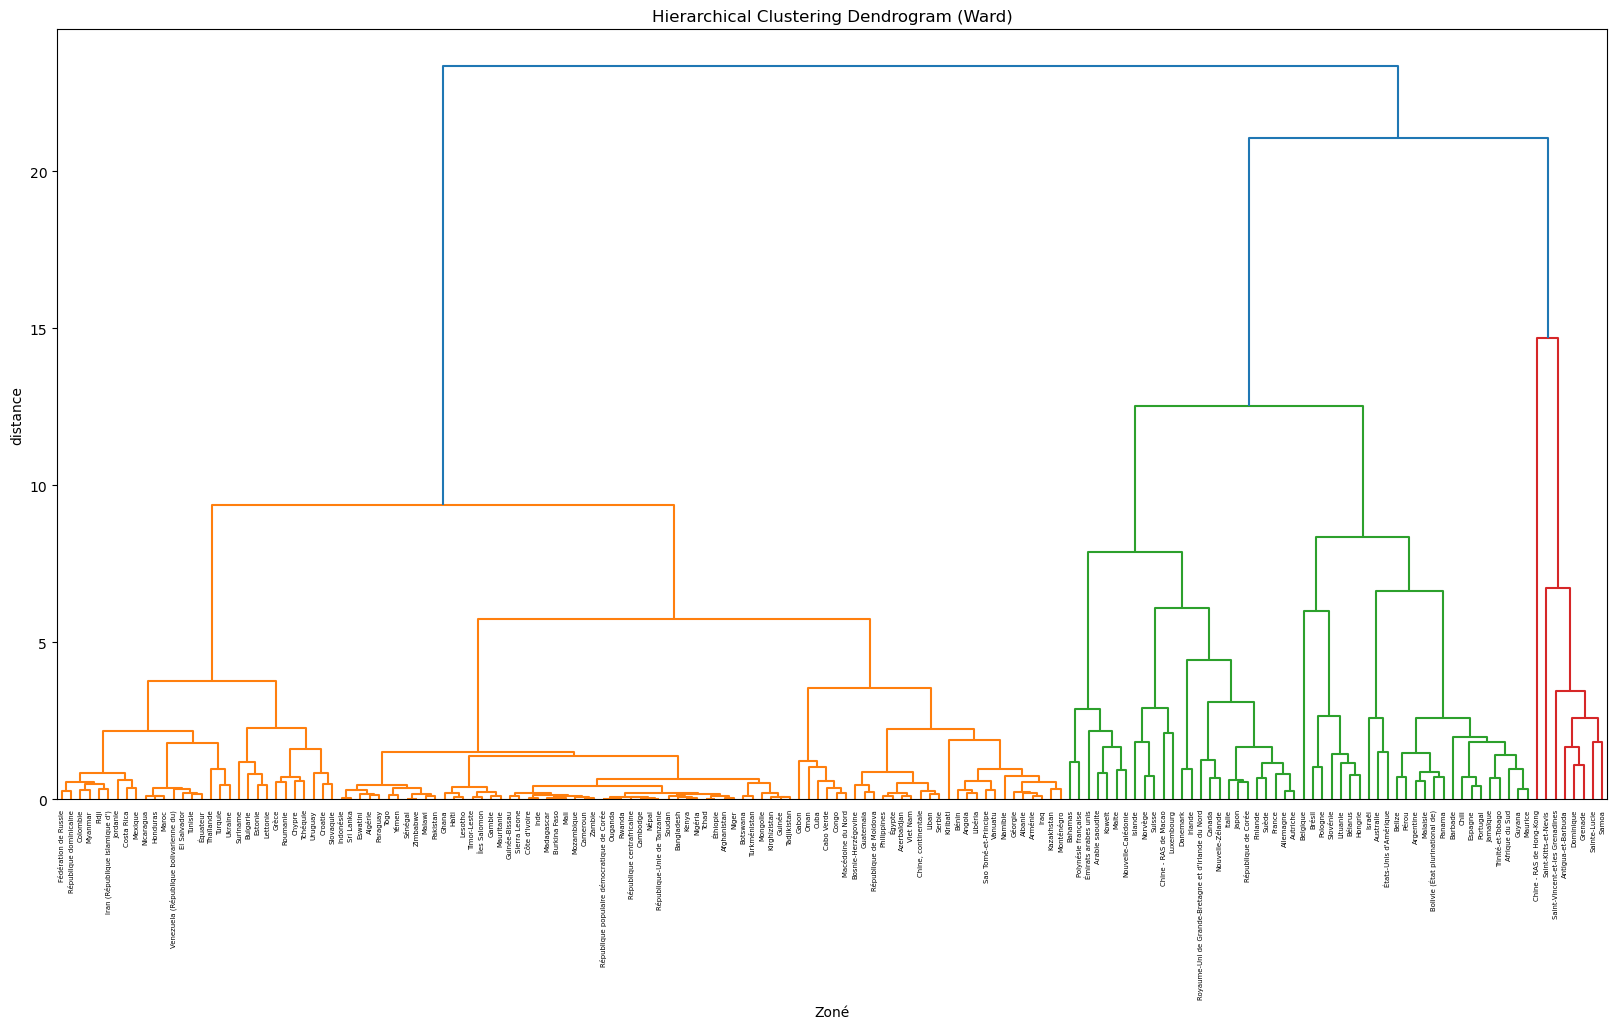

In [45]:
# Supposez que `X` est votre data et `zone` est votre colonne "Zoné"
Z = linkage(data_num, 'ward')

# Convertir la colonne "Zoné" en liste de strings
# Copiez la colonne "Zoné" dans une autre variable
zone = data['Zone'].copy()
labels = zone.astype(str).tolist()

plt.figure(figsize=(20, 10))
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Zoné')
plt.ylabel('distance')
dendrogram(Z, labels=labels, leaf_rotation=90)
plt.show()

In [46]:
data.head()

,Zone,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
0,Afghanistan,-1.184367,-0.276200,-0.324518,-0.537508,-0.898466,-0.700030
1,Afrique du Sud,1.228105,-0.270646,-0.207602,-0.099400,0.783244,-0.377988
2,Albanie,-0.167466,-0.224725,-0.324518,0.122397,-0.677767,-0.492489
3,Algérie,-0.930142,-0.275419,-0.324518,-0.577530,-0.551554,-0.512601
4,Allemagne,0.134759,-0.274256,0.502331,-0.036997,0.137925,1.595012


In [47]:
# Coupage du dendrogramme en 5 clusters
clusters = fcluster(Z, 5, criterion='maxclust')

# Creattion de différenes dataframes pour chaque cluster
cluster_dataframes = []
for cluster_id in range(1, 6):
    cluster_indices = [i for i, cluster_label in enumerate(clusters) if cluster_label == cluster_id]
    cluster_dataframe = data.iloc[cluster_indices]
    cluster_dataframes.append(cluster_dataframe)

# Creattion de clusters 
cluster_1_dd = cluster_dataframes[0]
cluster_2_dd = cluster_dataframes[1]
cluster_3_dd = cluster_dataframes[2]
cluster_4_dd = cluster_dataframes[3]
cluster_5_dd = cluster_dataframes[4]

cluster_1_dd.head()

,Zone,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
0,Afghanistan,-1.184367,-0.276200,-0.324518,-0.537508,-0.898466,-0.700030
2,Albanie,-0.167466,-0.224725,-0.324518,0.122397,-0.677767,-0.492489
3,Algérie,-0.930142,-0.275419,-0.324518,-0.577530,-0.551554,-0.512601
5,Angola,-0.640361,-0.273673,-0.324518,-0.084781,-0.860826,-0.517398
9,Arménie,-0.313246,-0.232433,-0.324518,0.053749,-0.723323,-0.517434


# V.PCA

In [48]:
from sklearn.decomposition import PCA

# Définir une plage de nombres de composantes à tester
plage_de_composantes = range(1, df.shape[1] + 1)

# Listes pour stocker la variance expliquée et la variance expliquée cumulative
variance_expliquee = []

# Itérer à travers différents nombres de composantes
for n_composantes in plage_de_composantes:
    pca_pivot = PCA(n_components=n_composantes)
    composantes_principales_pivot = pca_pivot.fit_transform(data_num)

    # Calculer la variance expliquée et la variance expliquée cumulative
    variance_expliquee.append(np.sum(pca_pivot.explained_variance_ratio_))

n_components = 6
pca = PCA(n_components=n_components)
pca.fit(data_num)

pca.explained_variance_ratio_

scree = (pca.explained_variance_ratio_*100).round(2)
scree

scree_cum = scree.cumsum().round()
scree_cum

x_list = range(1, n_components+1)
list(x_list)

# Tracer la variance expliquée et la variance expliquée cumulative
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

NameError: name 'df' is not defined

## ACP 2 components

In [ ]:
n_components = 6
pca = PCA(n_components=n_components)
pca.fit(data_num)


PCA(n_components=6)

In [ ]:
pca.explained_variance_ratio_

array([0.41381177, 0.26963516, 0.15621073, 0.11336747, 0.04153889,
       0.00543597])

In [ ]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([41.38, 26.96, 15.62, 11.34,  4.15,  0.54])

In [ ]:
scree_cum = scree.cumsum().round()
scree_cum

array([ 41.,  68.,  84.,  95.,  99., 100.])

In [ ]:
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4, 5, 6]

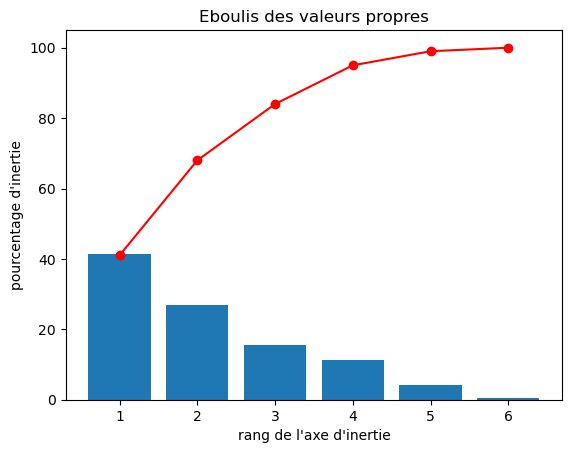

In [ ]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [ ]:
pcs = pca.components_
pcs

array([[ 0.5680289 ,  0.36802111,  0.32664891,  0.4973978 ,  0.23322139,
         0.3652497 ],
       [-0.10463794,  0.52843376, -0.25953916,  0.41344508, -0.61315338,
        -0.3091184 ],
       [-0.33949762, -0.31252867,  0.73734448,  0.24712707, -0.41249283,
         0.11030953],
       [-0.11027693, -0.04944519, -0.36895691, -0.06269543, -0.34046498,
         0.85405963],
       [-0.46724942,  0.68930963,  0.29749406, -0.38685159,  0.20554276,
         0.1616339 ],
       [-0.56626179, -0.10025702, -0.2400648 ,  0.60580685,  0.49125976,
         0.05767942]])

In [ ]:
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5
0,0.568029,0.368021,0.326649,0.497398,0.233221,0.365250
1,-0.104638,0.528434,-0.259539,0.413445,-0.613153,-0.309118
2,-0.339498,-0.312529,0.737344,0.247127,-0.412493,0.110310
3,-0.110277,-0.049445,-0.368957,-0.062695,-0.340465,0.854060
4,-0.467249,0.689310,0.297494,-0.386852,0.205543,0.161634
5,-0.566262,-0.100257,-0.240065,0.605807,0.491260,0.057679


In [ ]:
features = data_num.columns
features

Index(['Disponibilité de protéines en quantité (g/personne/an)',
       'Disponibilité intérieure/ Population', 'Exportations / Population',
       'Importations / Population', 'Production / Population',
       'PIB US $ par habitant'],
      dtype='object')

In [ ]:
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant
F1,0.57,0.37,0.33,0.50,0.23,0.37
F2,-0.10,0.53,-0.26,0.41,-0.61,-0.31
F3,-0.34,-0.31,0.74,0.25,-0.41,0.11
F4,-0.11,-0.05,-0.37,-0.06,-0.34,0.85
F5,-0.47,0.69,0.30,-0.39,0.21,0.16
F6,-0.57,-0.10,-0.24,0.61,0.49,0.06


In [ ]:
x, y = 0,1

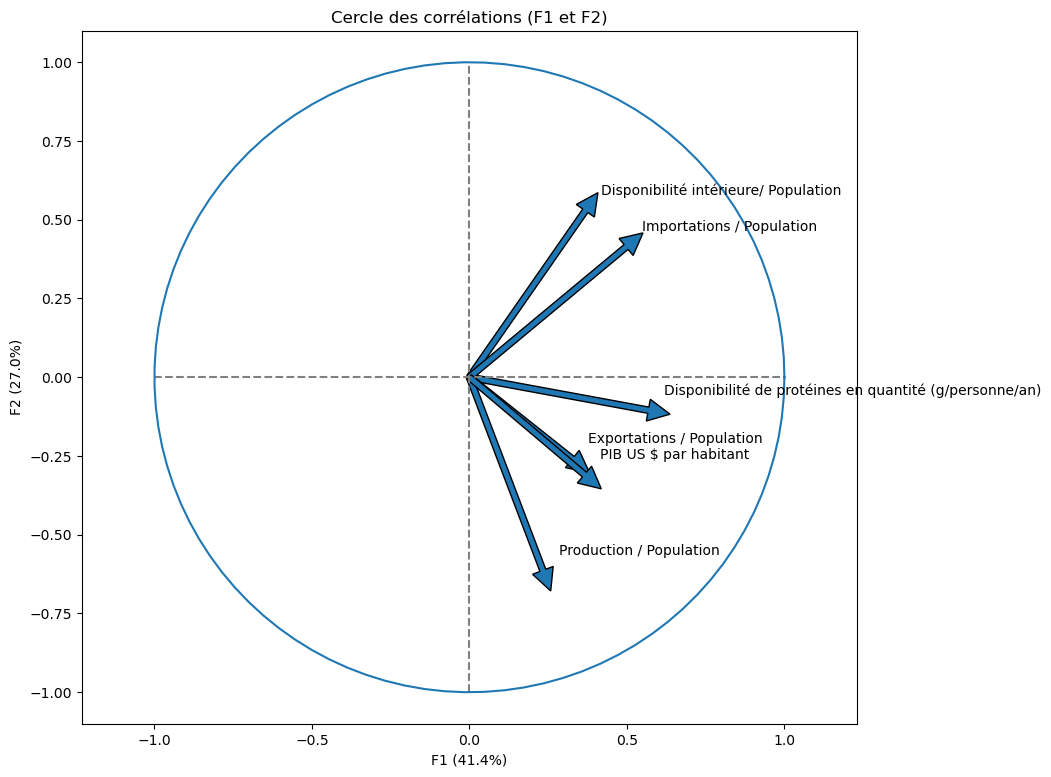

In [ ]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07,
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             features[i])

# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

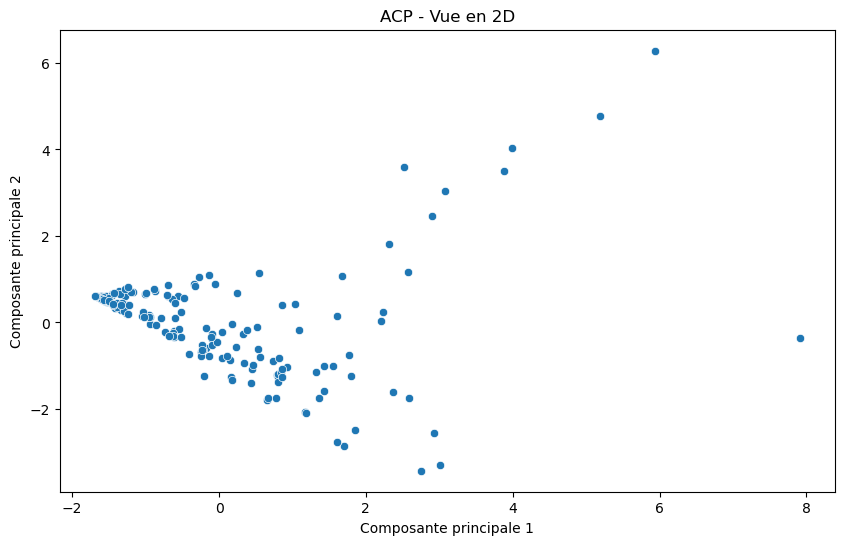

In [ ]:
# Application de l'ACP
pca_pivot = PCA(n_components=2)  # Ajuster le nombre de composantes
principal_components_pivot = pca_pivot.fit_transform(data_num)

# Visualisation des résultats de l'ACP
plt.figure(figsize=(10, 6))
sns.scatterplot(x=principal_components_pivot[:, 0], y=principal_components_pivot[:, 1])
plt.title('ACP - Vue en 2D')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()

In [ ]:
X_proj = pca.transform(data_num)
X_proj[:10]

array([[-1.61298829,  0.60726116,  0.40968676,  0.00572632,  0.17657895,
        -0.03112494],
       [ 0.52535111, -0.62214646, -0.87477111, -0.62871285, -0.68380266,
        -0.31570023],
       [-0.5609043 ,  0.60141308,  0.14330135, -0.04821997, -0.4394614 ,
        -0.09195188],
       [-1.33883505,  0.29387748,  0.19081976,  0.02212616,  0.17541381,
        -0.01817278],
       [ 0.73604336, -0.88231494,  0.5202623 ,  1.13095696,  0.19789692,
        -0.03206159],
       [-1.00237676,  0.65931656,  0.34070866,  0.06038996, -0.2137469 ,
        -0.03613859],
       [ 3.98873995,  4.03096785, -0.95755906, -0.08914596,  0.44216764,
         0.16505609],
       [ 1.09462351, -0.17292222, -0.52261617,  0.1404601 , -1.10695398,
        -0.29779667],
       [ 0.78216991, -1.75341639, -1.11599928, -0.77955288, -0.03050712,
        -0.03200606],
       [-0.70042865,  0.61985602,  0.19427704, -0.03325293, -0.36349781,
        -0.07403578]])

In [ ]:
X_proj = pd.DataFrame(X_proj, columns = ["F1", "F2","F3","F4","F5","F6"])
X_proj[:10]

,F1,F2,F3,F4,F5,F6
0,-1.612988,0.607261,0.409687,0.005726,0.176579,-0.031125
1,0.525351,-0.622146,-0.874771,-0.628713,-0.683803,-0.315700
2,-0.560904,0.601413,0.143301,-0.048220,-0.439461,-0.091952
3,-1.338835,0.293877,0.190820,0.022126,0.175414,-0.018173
4,0.736043,-0.882315,0.520262,1.130957,0.197897,-0.032062
5,-1.002377,0.659317,0.340709,0.060390,-0.213747,-0.036139
6,3.988740,4.030968,-0.957559,-0.089146,0.442168,0.165056
7,1.094624,-0.172922,-0.522616,0.140460,-1.106954,-0.297797
8,0.782170,-1.753416,-1.115999,-0.779553,-0.030507,-0.032006
9,-0.700429,0.619856,0.194277,-0.033253,-0.363498,-0.074036


## Cercle des corrélations

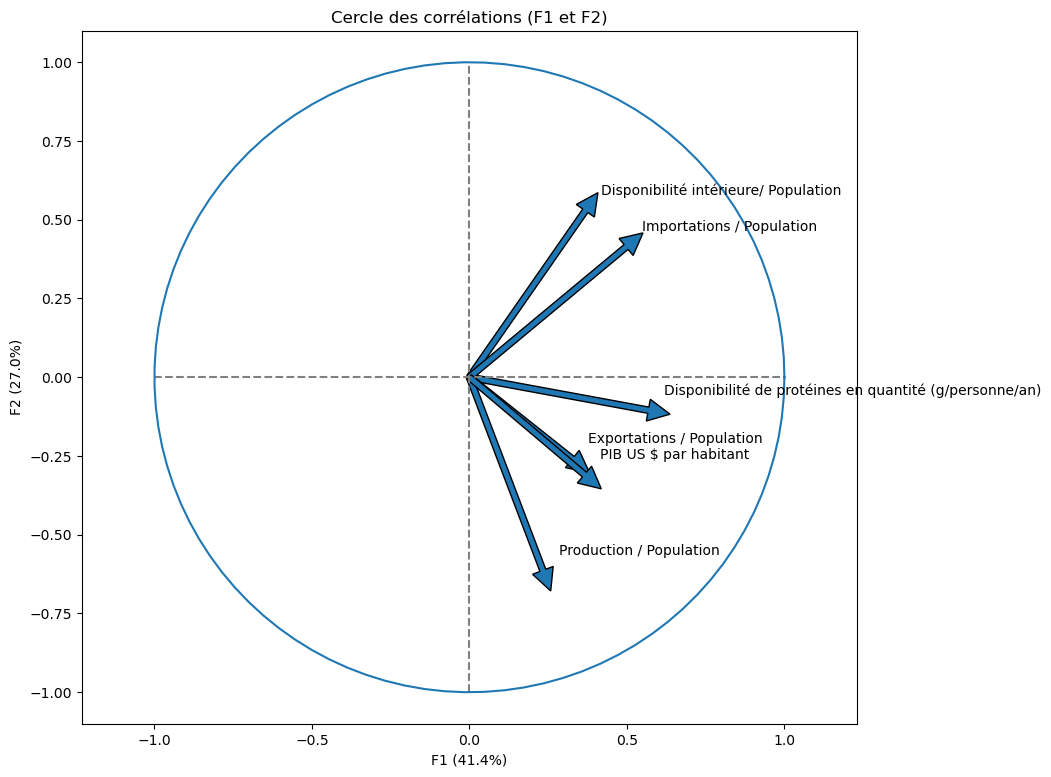

In [ ]:
def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

correlation_graph(pca, [0,1], features)

Text(0, 0.5, 'Eigenvalues')

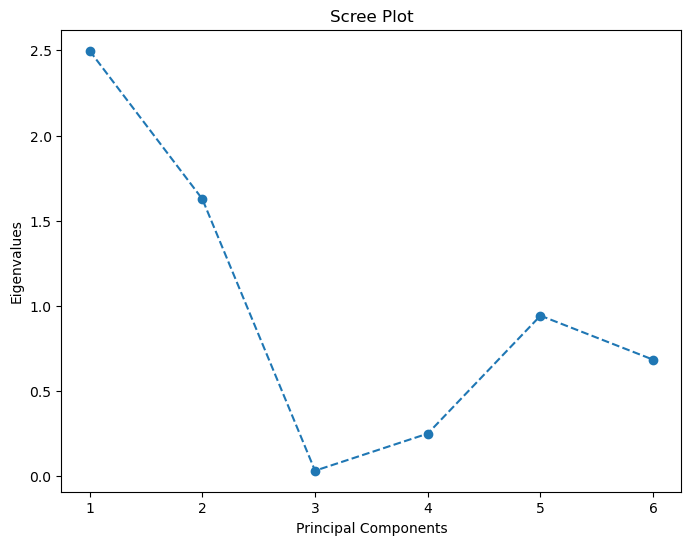

In [ ]:
# Calculate the covariance matrix
cov_matrix = np.cov(data_num.T)

# Calculate the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Plot the scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot")
plt.xlabel("Principal Components")
plt.ylabel("Eigenvalues")

# VI.Kmeans

In [ ]:
# Import the os module
import os

# Set the environment variable 'OMP_NUM_THREADS' to '1'
os.environ['OMP_NUM_THREADS'] = '1'

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Window

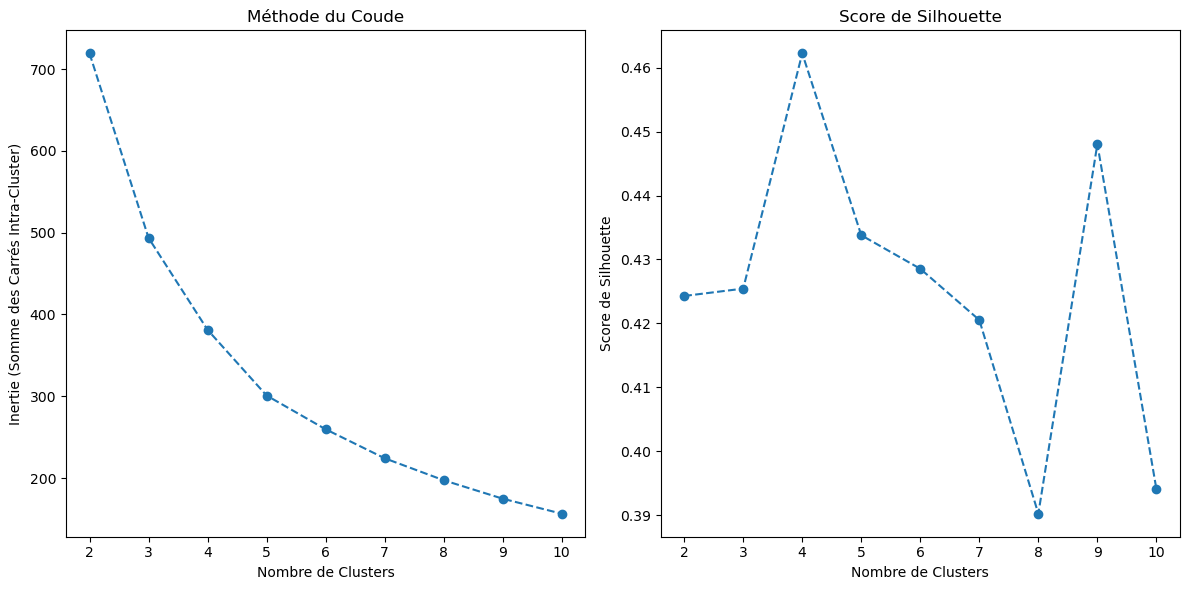

In [ ]:
# Définir une plage de nombres de clusters à tester
plage_de_clusters = range(2, 11)  # Vous pouvez ajuster la plage selon vos besoins

# Listes pour stocker l'inertie et les scores de silhouette
valeurs_inertie = []
scores_silhouette = []

# Itérer à travers différents nombres de clusters et ajuster K-Means
for n_clusters in plage_de_clusters:
    kmeans_pivot = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters_pivot = kmeans_pivot.fit_predict(data_num)

    # Calculer l'inertie (somme des carrés intra-cluster)
    valeurs_inertie.append(kmeans_pivot.inertia_)

    # Calculer le score de silhouette
    scores_silhouette.append(silhouette_score(data_num, clusters_pivot))

# Tracer la méthode du coude pour déterminer le nombre optimal de clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(plage_de_clusters, valeurs_inertie, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie (Somme des Carrés Intra-Cluster)')
plt.title('Méthode du Coude')

# Tracer le Score de Silhouette pour déterminer le nombre optimal de clusters
plt.subplot(1, 2, 2)
plt.plot(plage_de_clusters, scores_silhouette, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette')

plt.tight_layout()
plt.show()

Méthode du Coude (Elbow Method) :

La Méthode du Coude consiste à trouver le point dans un graphique de l'inertie où la diminution de l'inertie ralentit, formant un coude.
Ce point représente généralement le nombre optimal de clusters dans une analyse de clustering.

Score de Silhouette (Silhouette Score) :

Le Score de Silhouette mesure à quel point les points d'un cluster sont similaires entre eux et différents des autres clusters.
Il varie de -1 à 1, où un score élevé indique une meilleure séparation des clusters.
Le nombre optimal de clusters est généralement celui qui donne le score de silhouette le plus élevé.

In [ ]:
# Importer la classe KMeans du module sklearn.cluster
from sklearn.cluster import KMeans

# Créer une instance de la classe KMeans avec 2 clusters
kmeans = KMeans(n_clusters=4)

# Entraîner le modèle KMeans sur les données numériques
kmeans.fit(data_num)

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=4)

In [ ]:
# Obtenir les labels attribués par KMeans à chaque échantillon
labels = kmeans.labels_

# Ajouter la colonne 'cluster' au dataframe 'data' avec les labels attribués par KMeans
data['cluster'] = kmeans.labels_

# Afficher un échantillon aléatoire de 10 lignes du dataframe 'data' avec la colonne 'cluster'
data.sample(10)

,Zone,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant,cluster
40,Côte d'Ivoire,-1.127478,-0.275715,-0.324518,-0.564834,-0.803834,-0.619647,1
68,Iraq,-0.325691,-0.273141,-0.324518,0.087199,-0.793024,-0.481911,1
73,Jamaïque,1.512553,-0.148087,-0.288286,-0.014077,1.645355,-0.453420,0
168,Éthiopie,-1.273257,-0.276547,-0.324518,-0.579605,-0.936262,-0.690691,1
83,Liban,-0.587027,-0.262899,-0.262457,-0.478462,-0.389627,-0.276288,1
165,Émirats arabes unis,1.350773,-0.239305,0.723763,1.853325,-0.645165,1.483335,0
26,Cabo Verde,-0.121244,0.013364,-0.324518,0.611319,-0.834034,-0.564716,1
39,Cuba,-0.014576,-0.261562,-0.324518,0.886926,-0.792960,-0.283387,1
122,Royaume-Uni de Grande-Bretagne et d'Irlande du...,1.167660,-0.271628,0.244691,0.042331,0.661819,1.384302,0
44,El Salvador,-0.169244,-0.253193,-0.291394,-0.446565,0.313570,-0.520342,1


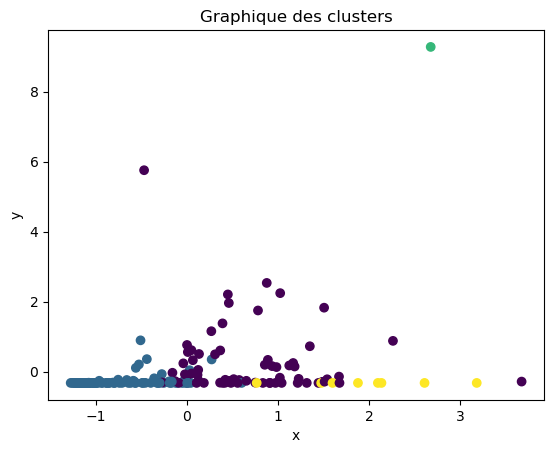

In [ ]:
# Créer un graphique de dispersion avec le numéro du cluster
plt.scatter(data['Disponibilité de protéines en quantité (g/personne/an)'], data['Exportations / Population'], c=data['cluster'])

# Ajouter des étiquettes et un titre
plt.xlabel('x')
plt.ylabel('y')
plt.title('Graphique des clusters')

# Afficher le graphique
plt.show()

In [ ]:
centroids = kmeans.cluster_centers_
centroids

array([[ 0.67491814, -0.13499801,  0.26378449, -0.03953144,  0.89596384,
         0.71141658],
       [-0.70714685, -0.23522392, -0.27059792, -0.31206415, -0.58673893,
        -0.54004513],
       [ 2.67701114, -0.20380277,  9.27639771,  6.03882173, -0.7499902 ,
         1.65050325],
       [ 1.96833621,  3.80235276, -0.32451822,  3.08694473, -0.80913537,
        -0.08891901]])

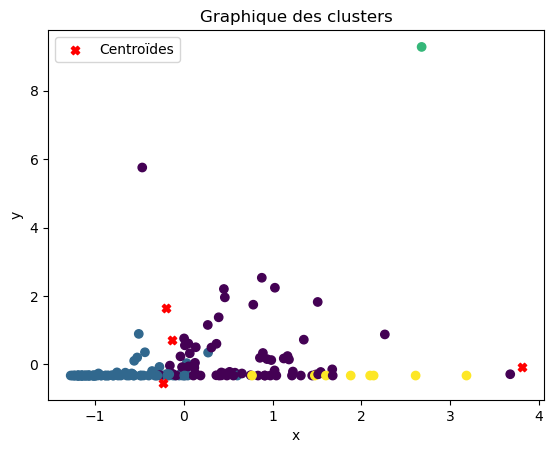

In [ ]:
# Créer un graphique de dispersion
plt.scatter(data['Disponibilité de protéines en quantité (g/personne/an)'], data['Exportations / Population'], c=data['cluster'])

# Ajouter des étiquettes et un titre
plt.xlabel('x')
plt.ylabel('y')
plt.title('Graphique des clusters')

# Ajouter les centroïdes au graphique
plt.scatter(centroids[:, 1], centroids[:, 5], marker='X', color='red', label='Centroïdes')

# Afficher le graphique
plt.legend()
plt.show()

### Cluster 1

In [ ]:
cluster_1 = data[data["cluster"]==0]

In [ ]:
cluster_1.describe()

,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant,cluster
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.0
mean,0.674918,-0.134998,0.263784,-0.039531,0.895964,0.711417,0.0
std,0.686563,0.277134,0.992491,0.652359,0.976090,1.224110,0.0
min,-0.467914,-0.275200,-0.324518,-0.580107,-0.944035,-0.659769,0.0
25%,0.122315,-0.270409,-0.316554,-0.494973,0.146587,-0.210863,0.0
50%,0.515208,-0.252503,-0.145502,-0.231385,0.663948,0.259638,0.0
75%,1.033436,-0.179692,0.413573,0.068954,1.575672,1.489430,0.0
max,3.674356,1.003358,5.753396,2.778401,3.563465,5.002357,0.0


In [ ]:
cluster_1.head(10)

,Zone,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant,cluster
1,Afrique du Sud,1.228105,-0.270646,-0.207602,-0.099400,0.783244,-0.377988,0
4,Allemagne,0.134759,-0.274256,0.502331,-0.036997,0.137925,1.595012,0
7,Arabie saoudite,1.487664,-0.265324,-0.292556,0.582830,0.155249,0.319478,0
8,Argentine,1.124993,-0.269202,0.173929,-0.570399,1.961290,0.032034,0
10,Australie,1.670777,-0.260432,-0.143769,-0.545407,2.105120,2.258492,0
11,Autriche,0.051203,-0.256276,0.611219,0.084911,0.047283,1.738481,0
13,Bahamas,1.316995,0.639095,-0.324518,2.778401,-0.013791,0.882669,0
15,Barbade,1.444997,1.003358,-0.324518,-0.207265,2.154066,0.200153,0
16,Belgique,-0.467914,-0.266999,5.753396,0.998045,1.451063,1.568600,0
17,Belize,0.188093,0.249405,-0.324518,-0.580107,2.206390,-0.410346,0


### Cluster 2

In [ ]:
cluster_2 = data[data["cluster"]==1]

In [ ]:
cluster_2.describe()

,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant,cluster
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.0
mean,-0.707147,-0.235224,-0.270598,-0.312064,-0.586739,-0.540045,1.0
std,0.442749,0.157899,0.178675,0.381858,0.371061,0.195125,0.0
min,-1.273257,-0.276547,-0.324518,-0.580107,-0.944035,-0.706031,1.0
25%,-1.089699,-0.275512,-0.324518,-0.577427,-0.850661,-0.673053,1.0
50%,-0.830585,-0.270630,-0.324518,-0.482830,-0.754968,-0.617996,1.0
75%,-0.333691,-0.253975,-0.322489,-0.121320,-0.394029,-0.495085,1.0
max,0.602320,1.116349,0.892310,1.383091,0.486445,0.248331,1.0


In [ ]:
cluster_2.head(10) 

,Zone,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant,cluster
0,Afghanistan,-1.184367,-0.276200,-0.324518,-0.537508,-0.898466,-0.700030,1
2,Albanie,-0.167466,-0.224725,-0.324518,0.122397,-0.677767,-0.492489,1
3,Algérie,-0.930142,-0.275419,-0.324518,-0.577530,-0.551554,-0.512601,1
5,Angola,-0.640361,-0.273673,-0.324518,-0.084781,-0.860826,-0.517398,1
9,Arménie,-0.313246,-0.232433,-0.324518,0.053749,-0.723323,-0.517434,1
12,Azerbaïdjan,-0.489248,-0.265762,-0.324518,-0.433886,-0.320030,-0.516621,1
14,Bangladesh,-1.196812,-0.276485,-0.324518,-0.580107,-0.851925,-0.634735,1
19,Bosnie-Herzégovine,-0.274134,-0.236224,-0.071941,-0.421001,0.131255,-0.454315,1
20,Botswana,-1.068810,-0.263669,-0.324518,-0.507567,-0.810088,-0.378954,1
22,Bulgarie,0.273428,-0.247170,0.345846,0.230674,-0.054069,-0.299033,1


### CLuster 3

In [ ]:
cluster_3 = data[data["cluster"]==2]

In [ ]:
cluster_3.describe()

,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant,cluster
count,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.0
mean,2.677011,-0.203803,9.276398,6.038822,-0.74999,1.650503,2.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.677011,-0.203803,9.276398,6.038822,-0.74999,1.650503,2.0
25%,2.677011,-0.203803,9.276398,6.038822,-0.74999,1.650503,2.0
50%,2.677011,-0.203803,9.276398,6.038822,-0.74999,1.650503,2.0
75%,2.677011,-0.203803,9.276398,6.038822,-0.74999,1.650503,2.0
max,2.677011,-0.203803,9.276398,6.038822,-0.74999,1.650503,2.0


In [ ]:
cluster_3.head(10)

,Zone,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant,cluster
31,Chine - RAS de Hong-Kong,2.677011,-0.203803,9.276398,6.038822,-0.74999,1.650503,2


### Cluster 4

In [ ]:
cluster_4 = data[data["cluster"]==3]

In [ ]:
cluster_4.describe()

,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant,cluster
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.0
mean,1.968336,3.802353,-0.324518,3.086945,-0.809135,-0.088919,3.0
std,0.732656,2.293053,0.000000,0.693249,0.205736,0.331359,0.0
min,0.767656,1.125000,-0.324518,2.317519,-0.944035,-0.506802,3.0
25%,1.568554,2.363024,-0.324518,2.413199,-0.944035,-0.318298,3.0
50%,1.988114,3.342958,-0.324518,3.080606,-0.944035,-0.192570,3.0
75%,2.254784,4.447976,-0.324518,3.596400,-0.701475,0.157295,3.0
max,3.181906,8.549254,-0.324518,4.067982,-0.407031,0.424635,3.0


In [ ]:
cluster_4.head(10)

,Zone,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant,cluster
6,Antigua-et-Barbuda,1.878780,4.189955,-0.324518,3.348463,-0.944035,0.110065,3
43,Dominique,0.767656,3.597793,-0.324518,2.423629,-0.944035,-0.343044,3
55,Grenade,1.475219,3.088123,-0.324518,2.812749,-0.407031,-0.243564,3
118,Polynésie française,1.599665,1.125000,-0.324518,2.317519,-0.730012,0.298982,3
131,Saint-Kitts-et-Nevis,2.136560,8.549254,-0.324518,3.521148,-0.944035,0.424635,3
132,Saint-Vincent-et-les Grenadines,3.181906,5.222040,-0.324518,3.822157,-0.944035,-0.310050,3
133,Sainte-Lucie,2.097449,2.243938,-0.324518,2.381910,-0.615866,-0.141575,3
134,Samoa,2.609455,2.402719,-0.324518,4.067982,-0.944035,-0.506802,3


### Cluster 5

In [ ]:
cluster_5 = data[data["cluster"]==4]

In [ ]:
cluster_5.describe()

,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant,cluster
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
cluster_5.head(10)

,Zone,Disponibilité de protéines en quantité (g/personne/an),Disponibilité intérieure/ Population,Exportations / Population,Importations / Population,Production / Population,PIB US $ par habitant,cluster
